In [1]:
from IPython.core.display import clear_output
import os
import numpy as np
import tensorflow as tf
import PIL
import matplotlib.pyplot as plt

In [2]:
# https://drive.google.com/file/d/1P3Cb4hZJ109177KfzVycmBHxpBxQEKFu/view?usp=sharing

!gdown 1P3Cb4hZJ109177KfzVycmBHxpBxQEKFu

Downloading...
From: https://drive.google.com/uc?id=1P3Cb4hZJ109177KfzVycmBHxpBxQEKFu
To: /content/datav5.zip
100% 63.7M/63.7M [00:01<00:00, 62.1MB/s]


In [3]:
!unzip "/content/datav5".zip
clear_output()

In [4]:
import pathlib
data_dir = "/content/data"
data_dir = pathlib.Path(data_dir)
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

1233


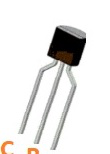

In [5]:
transistor = list(data_dir.glob('transistor/*'))
PIL.Image.open(str(transistor[0]))

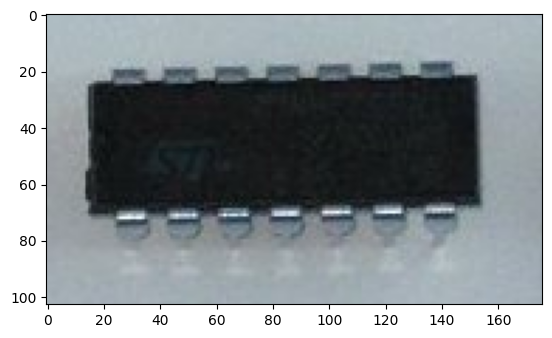

In [6]:
import cv2

img = cv2.imread("/content/data/integrated circuit/image11.jpg")
plt.imshow(img)

In [7]:
# Some of the image files are not accepted by Tensorflow, even though they are
# .jpg files, in order to find them below script applied
# source:https://stackoverflow.com/questions/68191448/unknown-image-file-format-one-of-jpeg-png-gif-bmp-required

from pathlib import Path
import imghdr

__data_dir = "/content/data"
image_extensions = [".png", ".jpg"]  # add there all your images file extensions

def check_images_for_tensorflow():

    global __data_dir
    global image_extensions

    images_needsto_convert = []

    img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]
    for filepath in Path(__data_dir).rglob("*"):
        if filepath.suffix.lower() in image_extensions:
            img_type = imghdr.what(filepath)
            if img_type is None:
                print(f"{filepath} is not an image")
                images_needsto_convert.append(filepath)
            elif img_type not in img_type_accepted_by_tf:
                print(f"{filepath} is a {img_type}, not accepted by TensorFlow")
                images_needsto_convert.append(filepath)
    return images_needsto_convert

In [8]:
image_list = check_images_for_tensorflow()

/content/data/resistor/image138.jpg is a webp, not accepted by TensorFlow
/content/data/resistor/image203.jpg is a webp, not accepted by TensorFlow
/content/data/resistor/image21.jpg is a webp, not accepted by TensorFlow
/content/data/diode/image151.jpg is a webp, not accepted by TensorFlow
/content/data/integrated circuit/image221.jpg is a webp, not accepted by TensorFlow
/content/data/integrated circuit/image83.jpg is not an image
/content/data/integrated circuit/image222.jpg is not an image
/content/data/integrated circuit/image208.jpg is a webp, not accepted by TensorFlow
/content/data/integrated circuit/image33.jpg is a webp, not accepted by TensorFlow
/content/data/capacitor/image217.jpg is not an image
/content/data/capacitor/image103.jpg is a webp, not accepted by TensorFlow
/content/data/transistor/image117.jpg is a webp, not accepted by TensorFlow
/content/data/transistor/image245.jpg is not an image
/content/data/transistor/image77.jpg is not an image
/content/data/transisto

In [9]:
for image_path in image_list:
    image = PIL.Image.open(image_path)
    # os.remove(image_path)
    image.convert("RGB").save(image_path, "JPEG")

In [10]:
image_list = check_images_for_tensorflow()
image_list

[]

In [11]:
batch_size = 32
img_height = 360
img_width = 480

In [12]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 1233 files belonging to 5 classes.
Using 987 files for training.


In [13]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 1233 files belonging to 5 classes.
Using 246 files for validation.


In [14]:
class_names = train_ds.class_names
class_names

['capacitor', 'diode', 'integrated circuit', 'resistor', 'transistor']

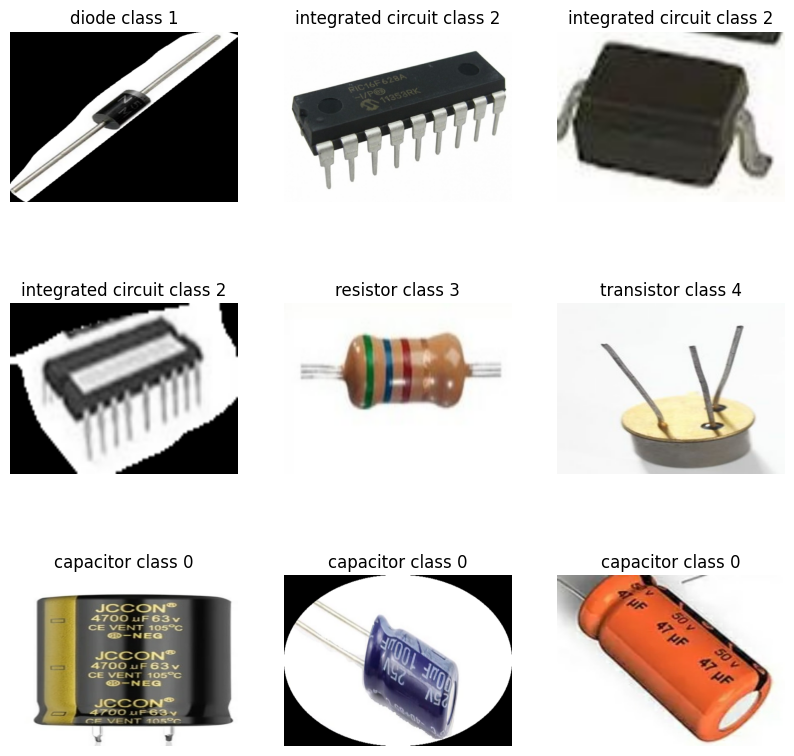

In [15]:
plt.figure(figsize=(10, 10))
for images, labels in val_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]] + " " + "class " + str(labels[i].numpy()))
        plt.axis("off")

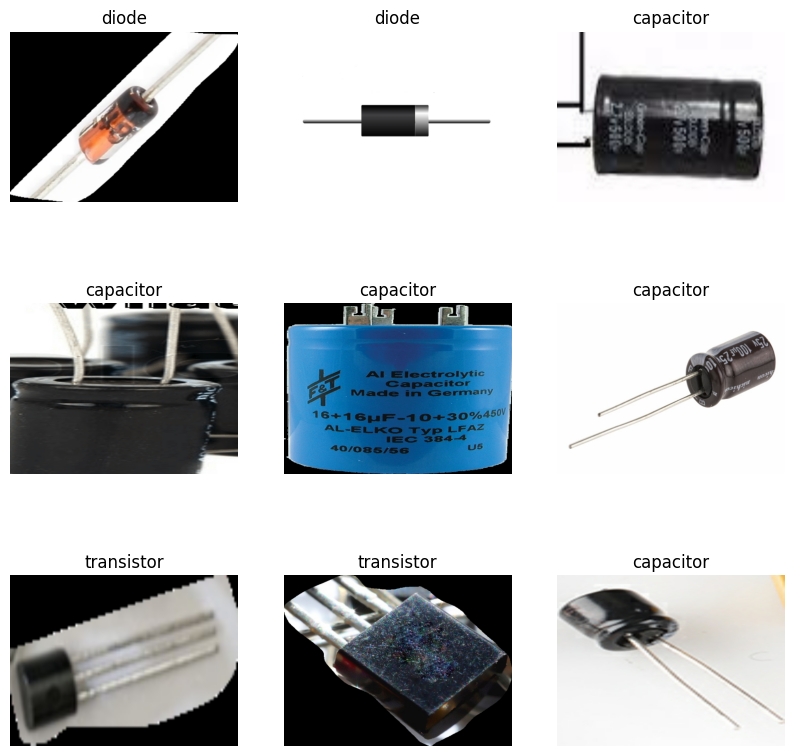

In [16]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [17]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.0 1.0


## Model From Scracth

In [18]:
num_classes = len(class_names)

model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_classes)
])

In [19]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 360, 480, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 360, 480, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 180, 240, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 180, 240, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 90, 120, 32)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 90, 120, 64)       1

In [21]:
epochs=10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/10
31/31 [==============================] - 23s 261ms/step - loss: 12.4229 - accuracy: 0.2239 - val_loss: 13.1041 - val_accuracy: 0.1870
Epoch 2/10
31/31 [==============================] - 8s 219ms/step - loss: 12.5254 - accuracy: 0.2229 - val_loss: 13.1041 - val_accuracy: 0.1870
Epoch 3/10
31/31 [==============================] - 7s 189ms/step - loss: 12.5254 - accuracy: 0.2229 - val_loss: 13.1041 - val_accuracy: 0.1870
Epoch 4/10
31/31 [==============================] - 8s 224ms/step - loss: 12.5254 - accuracy: 0.2229 - val_loss: 13.1041 - val_accuracy: 0.1870
Epoch 5/10
31/31 [==============================] - 8s 228ms/step - loss: 12.5254 - accuracy: 0.2229 - val_loss: 13.1041 - val_accuracy: 0.1870
Epoch 6/10
31/31 [==============================] - 8s 224ms/step - loss: 12.5254 - accuracy: 0.2229 - val_loss: 13.1041 - val_accuracy: 0.1870
Epoch 7/10
31/31 [==============================] - 7s 193ms/step - loss: 12.5254 - accuracy: 0.2229 - val_loss: 13.1041 - val_accuracy

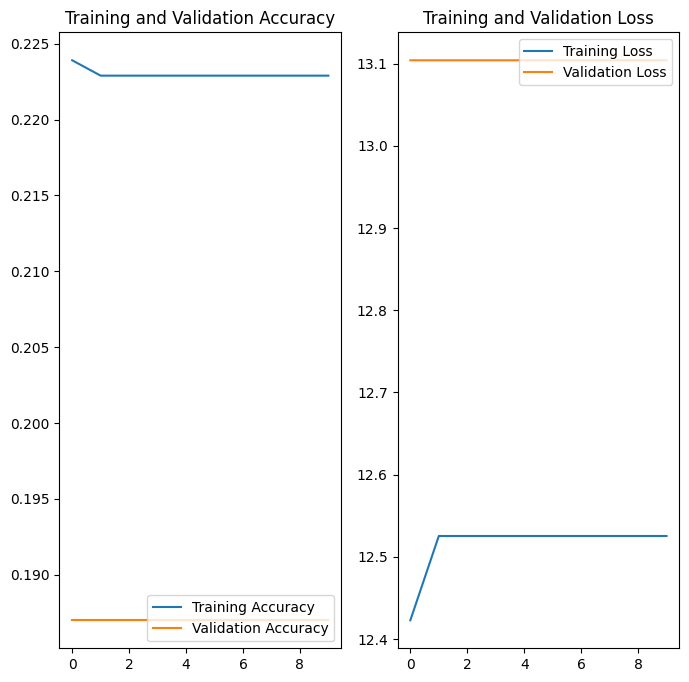

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Data Augmentation

In [23]:
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal_and_vertical",
                                   input_shape=(img_height,
                                                img_width,
                                                3)),
        tf.keras.layers.RandomRotation(0.1),
        tf.keras.layers.RandomZoom(0.1),
    ]
)

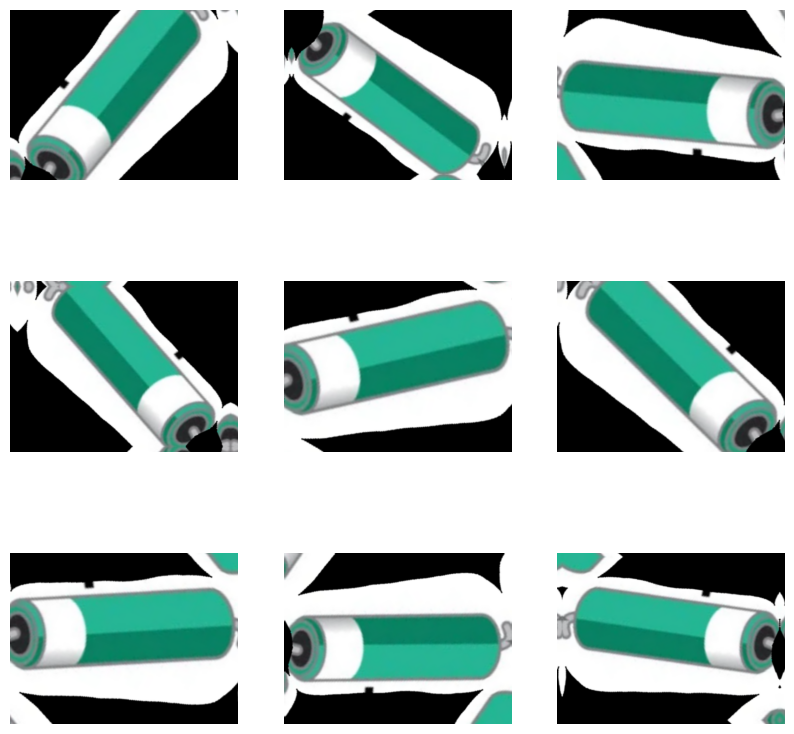

In [24]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [25]:
model = tf.keras.Sequential([
    data_augmentation,
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_classes, name="outputs")
])

In [26]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [27]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 360, 480, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 360, 480, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 360, 480, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 180, 240, 16)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 180, 240, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 90, 120, 32)      0         
 2D)                                                  

In [28]:
epochs = 20
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/20
31/31 [==============================] - 10s 225ms/step - loss: 2.4021 - accuracy: 0.2766 - val_loss: 1.5361 - val_accuracy: 0.3008
Epoch 2/20
31/31 [==============================] - 9s 230ms/step - loss: 1.4838 - accuracy: 0.3769 - val_loss: 1.4159 - val_accuracy: 0.3699
Epoch 3/20
31/31 [==============================] - 9s 250ms/step - loss: 1.3008 - accuracy: 0.4569 - val_loss: 1.1845 - val_accuracy: 0.5691
Epoch 4/20
31/31 [==============================] - 9s 249ms/step - loss: 1.1569 - accuracy: 0.5512 - val_loss: 1.2263 - val_accuracy: 0.5244
Epoch 5/20
31/31 [==============================] - 8s 224ms/step - loss: 1.0681 - accuracy: 0.5947 - val_loss: 1.0376 - val_accuracy: 0.6220
Epoch 6/20
31/31 [==============================] - 8s 222ms/step - loss: 1.0080 - accuracy: 0.5978 - val_loss: 1.1168 - val_accuracy: 0.5325
Epoch 7/20
31/31 [==============================] - 9s 255ms/step - loss: 0.9388 - accuracy: 0.6393 - val_loss: 0.9179 - val_accuracy: 0.7195
Epoch

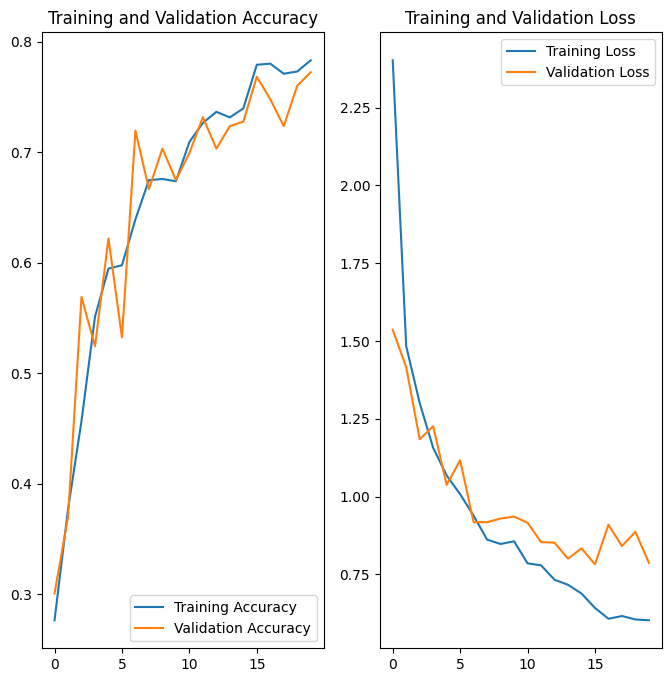

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Transfer Learning

In [102]:
val_batches = tf.data.experimental.cardinality(val_ds)
test_dataset = val_ds.take(val_batches // 5)
validation_dataset = val_ds.skip(val_batches // 5)

In [103]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(val_ds))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 8
Number of test batches: 1


In [104]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical",
                            input_shape=(img_height,
                                        img_width,
                                        3)),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])

In [105]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [106]:
IMG_SHAPE = (img_height, img_width, 3)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [107]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 12, 15, 1280)


In [108]:
base_model.trainable = False

In [109]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 360, 480, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 180, 240, 32  864         ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 180, 240, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [110]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [111]:
prediction_layer = tf.keras.layers.Dense(5, activation="softmax")
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 5)


In [112]:
inputs = tf.keras.Input(shape=(IMG_SHAPE))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [113]:
# initial learning rate = 0.0001
# second learning rate = 0.001
# third learning rate = 0.0005
base_learning_rate = 0.0005
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [114]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 360, 480, 3)]     0         
                                                                 
 sequential_5 (Sequential)   (None, 360, 480, 3)       0         
                                                                 
 tf.math.truediv_2 (TFOpLamb  (None, 360, 480, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_2 (TFOpLam  (None, 360, 480, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 12, 15, 1280)     2257984   
 ional)                                                          
                                                           

In [115]:
len(model.trainable_variables)

2

In [116]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(val_ds)

8/8 [==============================] - 4s 145ms/step - loss: 1.9617 - accuracy: 0.1870


In [117]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 1.96
initial accuracy: 0.19


After training, when predicting images, prediction result isn't correct as it should be.
Because of this, several things I tried:


1.   I added a few more data augmentation techniques.
2.   I reduced epochs variable from 20 to 18, because model learned too much
3.   I reduced a few epochs from 18 to 15 and I changed learning rate to 0.005 for bigger steps
4.   I reduced epochs to 10, and changed learning rate to 0.0005






1.   Best approach epochs=18, learning_rate=0.001
2.   List item



In [118]:
history = model.fit(train_ds,
                    epochs=10,
                    validation_data=val_ds)

Epoch 1/10
31/31 [==============================] - 16s 363ms/step - loss: 1.6481 - accuracy: 0.2877 - val_loss: 1.3990 - val_accuracy: 0.4431
Epoch 2/10
31/31 [==============================] - 10s 260ms/step - loss: 1.2893 - accuracy: 0.5187 - val_loss: 1.1389 - val_accuracy: 0.6504
Epoch 3/10
31/31 [==============================] - 10s 278ms/step - loss: 1.0707 - accuracy: 0.6565 - val_loss: 0.9684 - val_accuracy: 0.7439
Epoch 4/10
31/31 [==============================] - 9s 265ms/step - loss: 0.9263 - accuracy: 0.7285 - val_loss: 0.8450 - val_accuracy: 0.7846
Epoch 5/10
31/31 [==============================] - 9s 245ms/step - loss: 0.8184 - accuracy: 0.7589 - val_loss: 0.7586 - val_accuracy: 0.8089
Epoch 6/10
31/31 [==============================] - 8s 232ms/step - loss: 0.7446 - accuracy: 0.7913 - val_loss: 0.6892 - val_accuracy: 0.8333
Epoch 7/10
31/31 [==============================] - 9s 250ms/step - loss: 0.6792 - accuracy: 0.8176 - val_loss: 0.6428 - val_accuracy: 0.8496
Epo

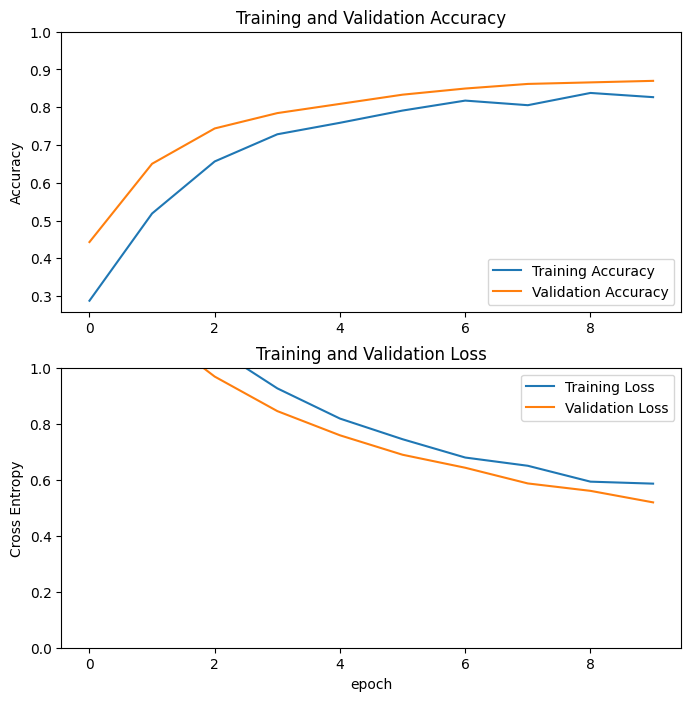

In [119]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [138]:
base_model.trainable = True

In [139]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


In [144]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [145]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 360, 480, 3)]     0         
                                                                 
 sequential_5 (Sequential)   (None, 360, 480, 3)       0         
                                                                 
 tf.math.truediv_2 (TFOpLamb  (None, 360, 480, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_2 (TFOpLam  (None, 360, 480, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 12, 15, 1280)     2257984   
 ional)                                                          
                                                           

In [146]:
len(model.trainable_variables)

56

In [147]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_ds)

Epoch 10/20


/usr/local/lib/python3.10/dist-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


31/31 [==============================] - 22s 335ms/step - loss: 0.7886 - accuracy: 0.7649 - val_loss: 0.3575 - val_accuracy: 0.9146
Epoch 11/20
31/31 [==============================] - 10s 286ms/step - loss: 0.4149 - accuracy: 0.8571 - val_loss: 0.3277 - val_accuracy: 0.8902
Epoch 12/20
31/31 [==============================] - 10s 299ms/step - loss: 0.3557 - accuracy: 0.8845 - val_loss: 0.2411 - val_accuracy: 0.9228
Epoch 13/20
31/31 [==============================] - 10s 297ms/step - loss: 0.2838 - accuracy: 0.9027 - val_loss: 0.1516 - val_accuracy: 0.9512
Epoch 14/20
31/31 [==============================] - 10s 273ms/step - loss: 0.2032 - accuracy: 0.9331 - val_loss: 0.1579 - val_accuracy: 0.9390
Epoch 15/20
31/31 [==============================] - 10s 295ms/step - loss: 0.1695 - accuracy: 0.9453 - val_loss: 0.2240 - val_accuracy: 0.9146
Epoch 16/20
31/31 [==============================] - 10s 283ms/step - loss: 0.1397 - accuracy: 0.9595 - val_loss: 0.1066 - val_accuracy: 0.9634
Epoc

In [155]:
print(val_acc)
history_fine.history['loss']

history_fine.history['val_accuracy']


[0.44308942556381226, 0.6504064798355103, 0.7439024448394775, 0.7845528721809387, 0.8089430928230286, 0.8333333134651184, 0.8495935201644897, 0.8617886304855347, 0.8658536672592163, 0.869918704032898, 0.9146341681480408, 0.8902438879013062, 0.922764241695404, 0.9512194991111755, 0.9390243887901306, 0.9146341681480408, 0.9634146094322205, 0.9552845358848572, 0.9715447425842285, 0.9756097793579102, 0.9593495726585388]


[0.9146341681480408,
 0.8902438879013062,
 0.922764241695404,
 0.9512194991111755,
 0.9390243887901306,
 0.9146341681480408,
 0.9634146094322205,
 0.9552845358848572,
 0.9715447425842285,
 0.9756097793579102,
 0.9593495726585388]

In [156]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']

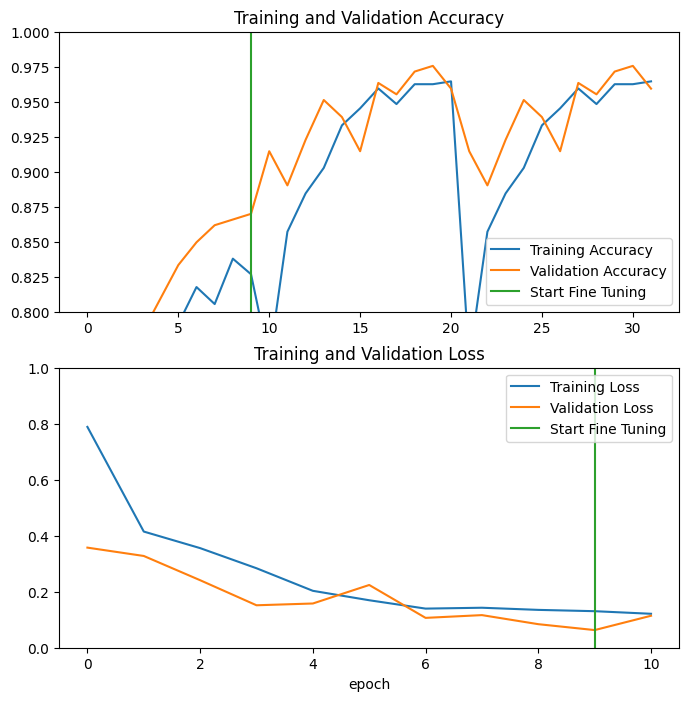

In [157]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [158]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

1/1 [==============================] - 1s 1s/step - loss: 0.1491 - accuracy: 0.9375
Test accuracy : 0.9375


In [159]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()

In [160]:
model.evaluate(image_batch, label_batch)

1/1 [==============================] - 0s 193ms/step - loss: 0.0909 - accuracy: 0.9688


[0.0909196063876152, 0.96875]

Predictions:
 [2, 0, 1, 0, 3, 1, 3, 3, 4, 1, 3, 2, 2, 2, 4, 4, 4, 2, 2, 3, 2, 2, 1, 3, 3, 2, 4, 1, 0, 2, 3, 4]
Labels:
 [2 0 1 0 3 1 3 3 4 1 3 2 2 2 4 4 4 2 2 3 2 2 1 3 3 2 4 1 2 2 3 4]


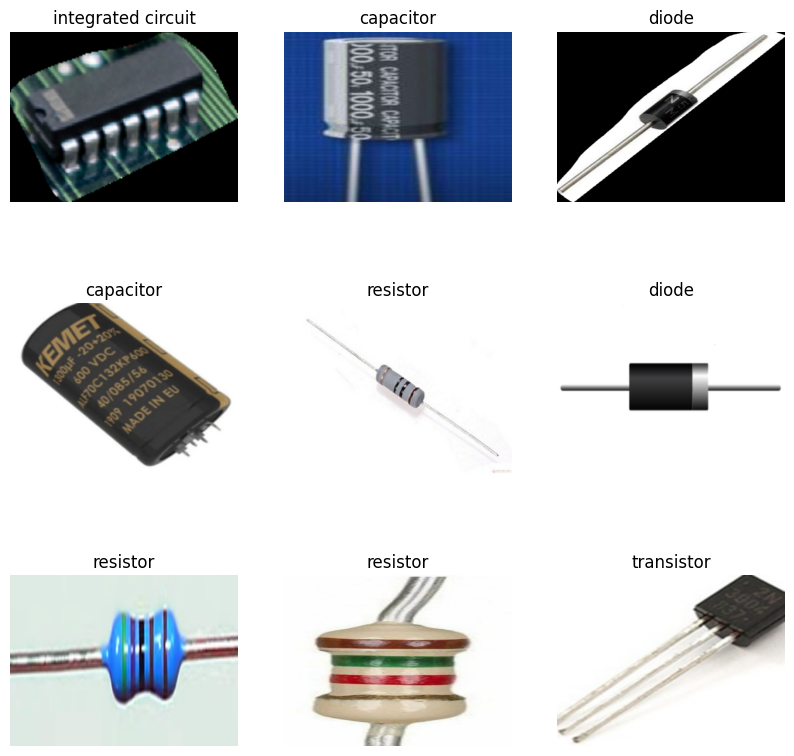

In [161]:
predictions = model.predict_on_batch(image_batch)
predictions = [tf.argmax(pred).numpy() for pred in predictions]

print('Predictions:\n', predictions)
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

In [180]:
test = cv2.imread("/content/test 9.jpeg")
test = cv2.resize(test, (360, 480))
test = tf.reshape(test, (1, 360, 480, 3))
prediction = model.predict(test)

1/1 [==============================] - 0s 38ms/step


In [181]:
prediction

array([[0.07630379, 0.00089975, 0.00352173, 0.2103012 , 0.7089736 ]],
      dtype=float32)

In [182]:
np.argmax(prediction)

4

In [184]:
import joblib

joblib.dump(model, 'model.pkl')

['model.pkl']

In [183]:
model.save("my_model")

In [185]:
!zip -r /content/my_model.zip /content/my_model

  adding: content/my_model/ (stored 0%)
  adding: content/my_model/variables/ (stored 0%)
  adding: content/my_model/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: content/my_model/variables/variables.index (deflated 76%)
  adding: content/my_model/assets/ (stored 0%)
  adding: content/my_model/keras_metadata.pb (deflated 96%)
  adding: content/my_model/fingerprint.pb (stored 0%)
  adding: content/my_model/saved_model.pb (deflated 91%)


In [186]:
from google.colab import files
files.download("/content/my_model.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [137]:
import os

path_capacitor = "/content/data/capacitor"
path_resistor = "/content/data/resistor"
path_diode = "/content/data/resistor"
path_ic = "/content/data/resistor"
path_transistor = "/content/data/resistor"

print(len(os.listdir(path_capacitor)))
print(len(os.listdir(path_resistor)))
print(len(os.listdir(path_diode)))
print(len(os.listdir(path_ic)))
print(len(os.listdir(path_transistor)))

267
255
255
255
255
